In [1]:
# 通过用户三个月的RFM 预测 LTV（一年的总消费额）
import numpy as np
import pandas as pd

df_sales = pd.read_csv('易速鲜花订单记录.csv')

In [2]:
#数据清洗===================
# 删除重复的行
df_sales = df_sales.drop_duplicates()
# 清洗掉数量小于0的数据行
df_sales = df_sales.loc[df_sales['数量'] > 0]
#总价
df_sales['总价'] = df_sales['数量'] * df_sales['单价']
df_sales.head()

# 求出 R F M
df_user = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构df_user
df_user.columns = ['用户码'] #设定字段名
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #按用户码排序
df_user #显示df_user


df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转化日期格式
df_recent_buy = df_sales.groupby('用户码').消费日期.max().reset_index() #构建消费日期信息
df_recent_buy.columns = ['用户码','最近日期'] #设定字段名
df_recent_buy['R值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days #计算最新日期与上次消费日期的天数
df_user = pd.merge(df_user, df_recent_buy[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_user.head() #显示df_user头几行数据

df_frequency = df_sales.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_frequency对象
df_frequency.columns = ['用户码','F值'] #设定字段名称
df_user = pd.merge(df_user, df_frequency, on='用户码') #把消费频率整合至df_user结构
df_user.head() #显示头几行数据

df_revenue = df_sales.groupby('用户码').总价.sum().reset_index() #根据消费总额，构建df_revenue对象
df_revenue.columns = ['用户码','M值'] #设定字段名称
df_user = pd.merge(df_user, df_revenue, on='用户码') #把消费金额整合至df_user结构
df_user.head() #显示头几行数据


#===========================

,用户码,R值,F值,M值
0,14681,70,7,498.95
1,14682,187,2,52.00
2,14684,25,390,1201.51
3,14687,106,15,628.38
4,14688,7,324,5579.10


In [3]:
print('日期范围： %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期'])
print('日期范围： %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))

日期范围： 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00
日期范围： 2020-06-01 09:09:00 ~ 2021-06-09 12:31:00


In [4]:
# 求整年的 LTV 所以 把不完整的 2021年6月数据删除 时间跨度：2020 年 6 月到 2021 年 6 月 9 号
df_sales = df_sales.loc[df_sales['消费日期'] < '2021-06-01']
print('日期范围： %s ~ %s' % (df_sales['消费日期'].min(), df_sales['消费日期'].max()))

日期范围： 2020-06-01 09:09:00 ~ 2021-05-31 17:37:00


In [5]:
# 构建特征和标签
# 构建仅含头三个月的数据
df_sales_3m = df_sales[(df_sales.消费日期 > '2020-06-01') & (df_sales.消费日期 <= '2020-08-30')]
# 索引重置
df_sales_3m.reset_index(drop=True)

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.40
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.60
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.20
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.50
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.50
...,...,...,...,...,...,...,...,...,...
14214,545190,22937,2020-08-29 15:32:00,产品说明掩码,6,18.00,15656,苏州,108.00
14215,545190,22722,2020-08-29 15:32:00,产品说明掩码,4,39.50,15656,苏州,158.00
14216,545190,22457,2020-08-29 15:32:00,产品说明掩码,60,3.00,15656,苏州,180.00
14217,545190,22464,2020-08-29 15:32:00,产品说明掩码,12,25.00,15656,苏州,300.00


In [6]:
df_user_LTV = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构
df_user_LTV.columns = ['用户码'] #设定字段名
df_user_LTV.head() #显示头几行数据
df_R_value = df_sales_3m.groupby('用户码').消费日期.max().reset_index() #找到每个用户的最近消费日期，构建df_R_value对象
df_R_value.columns = ['用户码','最近购买日期'] #设定字段名
df_R_value['R值'] = (df_R_value['最近购买日期'].max() - df_R_value['最近购买日期']).dt.days #计算最新日期与上次消费日期的天数
df_user_LTV = pd.merge(df_user_LTV, df_R_value[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_F_value = df_sales_3m.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_F_value对象
df_F_value.columns = ['用户码','F值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_F_value[['用户码','F值']], on='用户码') #把消费频率(F值)整合至df_user结构
df_M_value = df_sales_3m.groupby('用户码').总价.sum().reset_index() #计算每个用户三个月消费总额，构建df_M_value对象
df_M_value.columns = ['用户码','M值'] #设定字段名
df_user_LTV = pd.merge(df_user_LTV, df_M_value, on='用户码') #把消费总额整合至df_user结构
df_user_LTV #显示用户表结构

,用户码,R值,F值,M值
0,15100,49,3,876.00
1,15291,41,33,1372.19
2,14688,6,82,1491.37
3,15311,5,693,12859.50
4,15862,89,64,354.23
...,...,...,...,...
356,15951,1,22,375.17
357,14745,1,7,240.60
358,15724,0,5,103.65
359,15874,0,5,584.35


In [7]:
# 现根据数据算出每个用户据的LTV值 12个月的消费总额
# 构建每个用户整年消费总额
df_user_ly = df_sales.groupby('用户码')['总价'].sum().reset_index()
df_user_ly.columns = ['用户码', '年度LTV']
df_user_ly.head()
#构建整体LTV训练数据集
df_LTV = pd.merge(df_user_LTV, df_user_ly, on='用户码', how='left')
df_LTV

,用户码,R值,F值,M值,年度LTV
0,15100,49,3,876.00,876.00
1,15291,41,33,1372.19,4668.30
2,14688,6,82,1491.37,4949.83
3,15311,5,693,12859.50,59457.10
4,15862,89,64,354.23,659.73
...,...,...,...,...,...
356,15951,1,22,375.17,375.17
357,14745,1,7,240.60,1220.26
358,15724,0,5,103.65,218.25
359,15874,0,5,584.35,4405.88


In [8]:
# 创建特征集和标签集 特征集的X大写 标签集的y小写 （惯例）
X = df_LTV.drop(['用户码','年度LTV'], axis=1)
X.head()

,R值,F值,M值
0,49,3,876.00
1,41,33,1372.19
2,6,82,1491.37
3,5,693,12859.50
4,89,64,354.23


In [9]:
y = df_LTV['年度LTV']
y.head()

0      876.00
1     4668.30
2     4949.83
3    59457.10
4      659.73
Name: 年度LTV, dtype: float64

In [16]:
from sklearn.model_selection import train_test_split
# 先拆分训练集和其它集
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.7,random_state = 36)
# 再把其它集拆分成验证集和测试集 
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5,random_state = 36)

In [17]:
# 训练模型并不是一开始就挑好使用什么模型进行训练的而是将合适的模型都训练进行尝试对比
# 这里使用 线性回归、决策树、随机森林对比
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

model_lr = LinearRegression()
model_dtr = DecisionTreeRegressor()
model_rfr = RandomForestRegressor()

In [18]:
# 训练 启动
model_lr.fit(X_train, y_train)
model_dtr.fit(X_train, y_train)
model_rfr.fit(X_train, y_train)

RandomForestRegressor()

In [19]:
# 评估模型
y_valid_preds_lr = model_lr.predict(X_valid)
y_valid_preds_dtr = model_dtr.predict(X_valid)
y_valid_preds_rfr = model_rfr.predict(X_valid)

In [26]:
X_valid.iloc[5]

R值     74.00
F值     22.00
M值    270.19
Name: 181, dtype: float64

In [25]:
print('真值：', y_valid.iloc[5])
print('线性回归预测值：', y_valid_preds_lr[5])
print('决策树预测值：', y_valid_preds_dtr[5])
print('随机森林预测值：', y_valid_preds_rfr[5])

真值： 1400.44
线性回归预测值： 873.1440313300203
决策树预测值： 1887.2
随机森林预测值： 925.0460999999992


In [28]:
# 使用R方指标 评估模型预测准确度
from sklearn.metrics import r2_score
print('验证集上的R平方分数-lr： %0.4f' % r2_score(y_valid, model_lr.predict(X_valid)))
print('验证集上的R方分数-dtr： %0.4f' % r2_score(y_valid, model_dtr.predict(X_valid)))
print('验证集上的R方分数-rfr： %0.4f' % r2_score(y_valid, model_rfr.predict(X_valid)))

验证集上的R平方分数-lr： 0.2983
验证集上的R方分数-dtr： 0.3299
验证集上的R方分数-rfr： 0.3233


In [35]:
import matplotlib.pyplot as plt
# 设置中文字体为 SimHei（黑体），解决中文乱码
plt.rcParams['font.family'] = 'SimHei'
# 设置负号正常显示
plt.rcParams['axes.unicode_minus'] = False

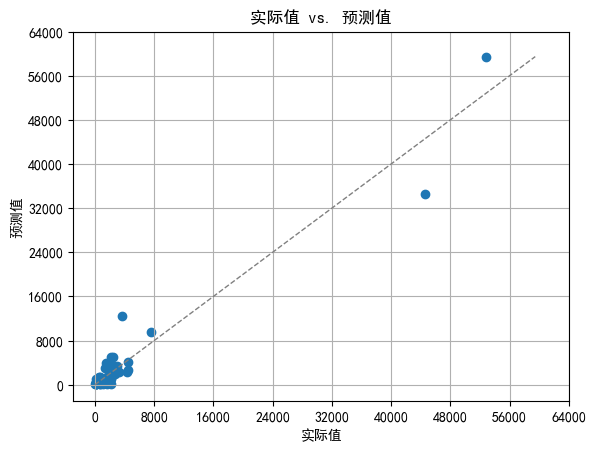

In [47]:
y_test_preds_dtr = model_dtr.predict(X_test)

# 获取最小和最大值
min_val = min(min(y_test), min(y_test_preds_dtr))
max_val = max(max(y_test), max(y_test_preds_dtr))

# 自动计算一个合理的刻度间隔（例如想要大约 8 个刻度）
interval = int(np.ceil((max_val - min_val) / 8 / 1000)) * 1000  # 向上取整到1000的倍数
ticks = np.arange(0, max_val + interval, interval)

plt.scatter(y_test, y_test_preds_dtr)
plt.plot([0, max_val], [0, max_val], color='gray', lw=1, linestyle='--')

plt.xticks(ticks)
plt.yticks(ticks)

plt.xlabel('实际值')
plt.ylabel('预测值')
plt.title('实际值 vs. 预测值')
plt.grid(True)
plt.show()
